# Виконання завдання для Wine Quality Dataset

## Крок 1: Імпорт бібліотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
sns.set_theme(style='darkgrid', palette='deep')
import warnings
warnings.filterwarnings('ignore')


Matplotlib created a temporary cache directory at /var/folders/t1/w5ktxn5j25n31cysspss6y880000gn/T/matplotlib-kj2ujyvw because the default path (/Users/raymond/.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.


## Крок 2: Завантаження та первинний аналіз даних

In [2]:
# Завантажуємо датасети
df_red = pd.read_csv('wine-quality/winequality-red.csv', delimiter=';')
df_white = pd.read_csv('wine-quality/winequality-white.csv', delimiter=';')

# Додаємо колонку для ідентифікації типу вина
df_red['type'] = 'red'
df_white['type'] = 'white'

# Об'єднуємо два датасети в один
df = pd.concat([df_red, df_white], ignore_index=True)

# Переглядаємо загальну інформацію про дані
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  type                  6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


Перевірка на відсутність пропусків та первинний опис: числові ознаки та їх розподіл.

In [3]:
# Перевірка пропусків
missing_values = df.isnull().sum()
print(missing_values)


fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
type                    0
dtype: int64


In [4]:
description = df.describe()
print(description)

       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    6497.000000       6497.000000  6497.000000     6497.000000   
mean        7.215307          0.339666     0.318633        5.443235   
std         1.296434          0.164636     0.145318        4.757804   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.400000          0.230000     0.250000        1.800000   
50%         7.000000          0.290000     0.310000        3.000000   
75%         7.700000          0.400000     0.390000        8.100000   
max        15.900000          1.580000     1.660000       65.800000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  6497.000000          6497.000000           6497.000000  6497.000000   
mean      0.056034            30.525319            115.744574     0.994697   
std       0.035034            17.749400             56.521855     0.002999   
min       0.009000             1.000000         

## Крок 3: Інжиніринг ознак

### Співвідношення алкоголю до густини

Вина з більш високим вмістом алкоголю, зазвичай, мають нижчу густину, тому це співвідношення може допомогти моделі визначити властивості вина, пов’язані з його міцністю.

In [5]:
df['alcohol_density_ratio'] = df['alcohol'] / df['density']

### Cпіввідношення якості до фіксованої кислотності

Може допомогти моделі краще розрізняти різні сорти вин за якістю.

In [6]:
df['quality_acidity_ratio'] = df['quality'] / df['fixed acidity']

### Перевірка на кореляцію

Перевірка на кореляцію допомагає виявити, наскільки сильно пов’язані між собою різні ознаки в датасеті.

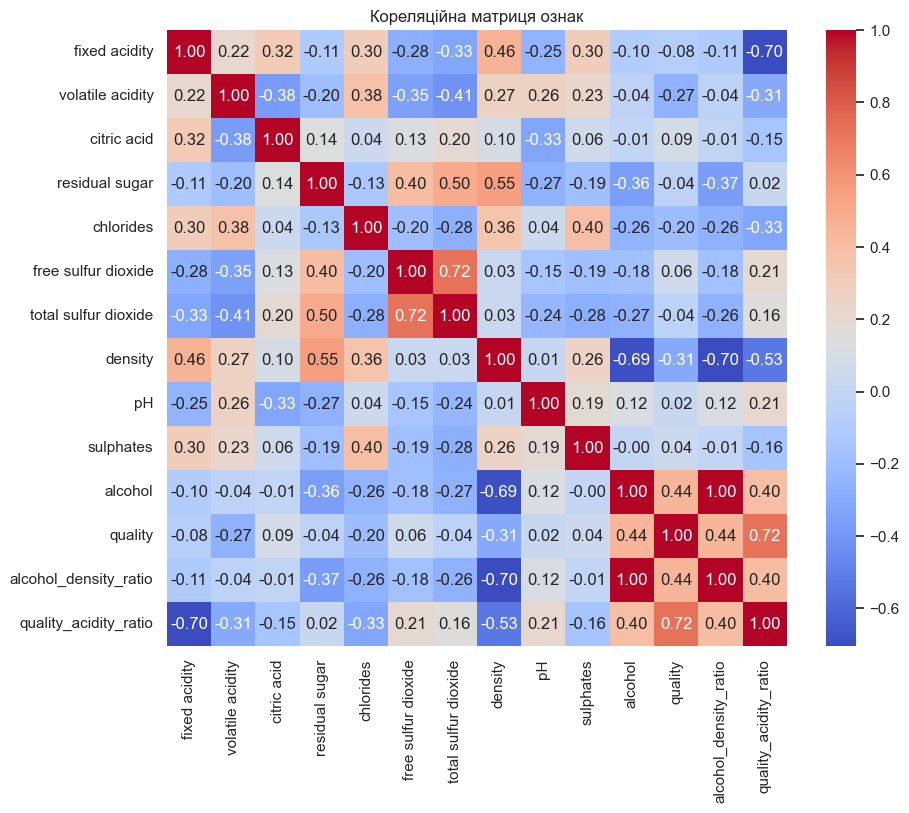

In [ ]:
plt.figure(figsize=(10, 8))
#sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')

# Видаляю колонку type бо вона не є числовою а це рядкові значення
sns.heatmap(df.drop(columns=['type']).corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Кореляційна матриця ознак")
plt.show()


Кореляційна матриця візуалізує зв'язки між ознаками, де:

* 1 означає високу позитивну кореляцію,
* -1 — високу негативну кореляцію,
* 0 — відсутність кореляції.

1. total sulfur dioxide і free sulfur dioxide. Це означає, що при побудові моделі можна спробувати видалити одну з цих ознак, бо сильно корелюють
2. Сильна негативна кореляція між fixed acidity та quality (-0.70). Це означає, що збільшення фіксованої кислотності часто пов’язане зі зниженням якості вина
3. Сильна негативна кореляція між density та alcohol (-0.69). Цей зв’язок показує, що вина з більш високим вмістом алкоголю зазвичай мають нижчу щільність. Це може бути пов’язано з тим, що алкоголь має меншу щільність, ніж вода.

## Крок 4: Масштабування ознак

In [ ]:
# Масштабуємо ознаки для лінійної регресії
scaler = StandardScaler()
features = df.drop(['quality', 'type'], axis=1)
scaled_features = scaler.fit_transform(features)
scaled_df = pd.DataFrame(scaled_features, columns=features.columns)
scaled_df['quality'] = df['quality'].values

# Перевірка перших рядків
scaled_df.head()


## Крок 5: Поділ датасету

In [ ]:
# Поділяємо на тренувальну, валідаційну та тестову вибірки
X = scaled_df.drop('quality', axis=1)
y = scaled_df['quality']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_train.shape, X_val.shape, X_test.shape


## Крок 6: Навчання базової моделі лінійної регресії

In [ ]:
# Навчання базової моделі лінійної регресії
model = LinearRegression()
model.fit(X_train, y_train)

# Оцінка на валідаційній вибірці
y_val_pred = model.predict(X_val)
mse = mean_squared_error(y_val, y_val_pred)
mae = mean_absolute_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)

mse, mae, r2


## Крок 7: Підбір гіперпараметрів

In [ ]:
# Використовуємо GridSearchCV для підбору гіперпараметрів
param_grid = {'fit_intercept': [True, False], 'normalize': [True, False]}
grid_search = GridSearchCV(LinearRegression(), param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

# Найкращі параметри
best_params = grid_search.best_params_
best_score = -grid_search.best_score_

best_params, best_score


## Крок 8: Оцінка результатів на тестовій вибірці

In [ ]:
# Перевірка продуктивності моделі з найкращими параметрами на тестовій вибірці
best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test)

# Оцінка на тестовій вибірці
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

test_mse, test_mae, test_r2
